# Image Captioning Inference - Test Your Trained Model

Use this notebook to generate captions for images using your trained model.

## Prerequisites:
1. You must have already trained the model
2. Model checkpoints should be saved in Google Drive
3. Mount Google Drive and run the cells below

In [27]:
# Install required packages
%pip install -q transformers torch torchvision pillow matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import libraries
import torch
import torch.nn as nn
from transformers import ViTModel, ViTConfig
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import math
import os
from collections import Counter

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

c:\Users\ckula\Projects\Image-captioning-using-ViT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All imports successful!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA T500


In [2]:
# Vocabulary Class Definition (Required for loading vocab.pth)

class Vocabulary:
    """Vocabulary class for caption tokenization"""

    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        """Build vocabulary from list of sentences"""
        frequencies = Counter()
        idx = 4  # Start after special tokens

        for sentence in sentence_list:
            for word in sentence.lower().split():
                frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        """Convert text to list of indices"""
        tokenized_text = text.lower().split()
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

print("Vocabulary class defined successfully!")

Vocabulary class defined successfully!


In [3]:
# Helper Functions

def load_model(checkpoint_path, vocab, device='cuda'):
    """Load trained model from checkpoint"""
    print(f"Loading model from {checkpoint_path}...")

    # Load checkpoint with PyTorch 2.6+ compatibility
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
    except Exception as e:
        print(f"Note: Using weights_only=False for compatibility")
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    config = checkpoint['config']

    model = ImageCaptioningModel(
        vocab_size=len(vocab),
        embed_dim=config['embed_dim'],
        num_decoder_layers=config['num_decoder_layers'],
        num_heads=config['num_heads'],
        forward_expansion=config['forward_expansion'],
        dropout=config['dropout'],
        max_length=config['max_length'],
        pretrained_vit=config['pretrained_vit']
    )

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    print(f"Model loaded successfully!")
    print(f"Trained for {checkpoint['epoch'] + 1} epochs")
    print(f"Best validation loss: {checkpoint['best_val_loss']:.4f}")

    return model


def preprocess_image(image_path, image_size=224):
    """Load and preprocess image for model input"""
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)

    return image, image_tensor


def generate_and_display_caption(model, vocab, image_path, device='cuda', use_beam_search=False, beam_width=5):
    """Generate caption for an image and display result"""
    original_image, image_tensor = preprocess_image(image_path)
    image_tensor = image_tensor.to(device)

    if use_beam_search:
        print(f"Generating caption using beam search (beam_width={beam_width})...")
        caption_words = model.generate_caption_beam_search(
            image_tensor, vocab, beam_width=beam_width, device=device
        )
    else:
        print("Generating caption using greedy decoding...")
        caption_words = model.generate_caption(image_tensor, vocab, device=device)

    caption = ' '.join(caption_words)

    plt.figure(figsize=(10, 8))
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"Generated Caption:\n{caption}", fontsize=14, pad=20, wrap=True)
    plt.tight_layout()
    plt.show()

    print(f"\nGenerated Caption: {caption}")
    return caption


def test_multiple_images(model, vocab, image_paths, device='cuda', use_beam_search=False):
    """Test model on multiple images and display in a grid"""
    n_images = len(image_paths)
    cols = 2
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if n_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, image_path in enumerate(image_paths):
        original_image, image_tensor = preprocess_image(image_path)
        image_tensor = image_tensor.to(device)

        if use_beam_search:
            caption_words = model.generate_caption_beam_search(
                image_tensor, vocab, beam_width=5, device=device
            )
        else:
            caption_words = model.generate_caption(image_tensor, vocab, device=device)

        caption = ' '.join(caption_words)

        axes[idx].imshow(original_image)
        axes[idx].axis('off')
        axes[idx].set_title(f"{caption}", fontsize=12, wrap=True)

        print(f"Image {idx + 1}: {caption}")

    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

print("Helper functions defined successfully!")

Helper functions defined successfully!


In [4]:
# Helper Functions

def load_model(checkpoint_path, vocab, device='cuda'):
    """Load trained model from checkpoint"""
    print(f"Loading model from {checkpoint_path}...")

    checkpoint = torch.load(checkpoint_path, map_location=device)
    config = checkpoint['config']

    model = ImageCaptioningModel(
        vocab_size=len(vocab),
        embed_dim=config['embed_dim'],
        num_decoder_layers=config['num_decoder_layers'],
        num_heads=config['num_heads'],
        forward_expansion=config['forward_expansion'],
        dropout=config['dropout'],
        max_length=config['max_length'],
        pretrained_vit=config['pretrained_vit']
    )

    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    print(f"Model loaded successfully!")
    print(f"Trained for {checkpoint['epoch'] + 1} epochs")
    print(f"Best validation loss: {checkpoint['best_val_loss']:.4f}")

    return model


def preprocess_image(image_path, image_size=224):
    """Load and preprocess image for model input"""
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)

    return image, image_tensor


def generate_and_display_caption(model, vocab, image_path, device='cuda', use_beam_search=False, beam_width=5):
    """Generate caption for an image and display result"""
    original_image, image_tensor = preprocess_image(image_path)
    image_tensor = image_tensor.to(device)

    if use_beam_search:
        print(f"Generating caption using beam search (beam_width={beam_width})...")
        caption_words = model.generate_caption_beam_search(
            image_tensor, vocab, beam_width=beam_width, device=device
        )
    else:
        print("Generating caption using greedy decoding...")
        caption_words = model.generate_caption(image_tensor, vocab, device=device)

    caption = ' '.join(caption_words)

    plt.figure(figsize=(10, 8))
    plt.imshow(original_image)
    plt.axis('off')
    plt.title(f"Generated Caption:\n{caption}", fontsize=14, pad=20, wrap=True)
    plt.tight_layout()
    plt.show()

    print(f"\nGenerated Caption: {caption}")
    return caption


def test_multiple_images(model, vocab, image_paths, device='cuda', use_beam_search=False):
    """Test model on multiple images and display in a grid"""
    n_images = len(image_paths)
    cols = 2
    rows = (n_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if n_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, image_path in enumerate(image_paths):
        original_image, image_tensor = preprocess_image(image_path)
        image_tensor = image_tensor.to(device)

        if use_beam_search:
            caption_words = model.generate_caption_beam_search(
                image_tensor, vocab, beam_width=5, device=device
            )
        else:
            caption_words = model.generate_caption(image_tensor, vocab, device=device)

        caption = ' '.join(caption_words)

        axes[idx].imshow(original_image)
        axes[idx].axis('off')
        axes[idx].set_title(f"{caption}", fontsize=12, wrap=True)

        print(f"Image {idx + 1}: {caption}")

    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

print("Helper functions defined successfully!")

Helper functions defined successfully!


In [5]:
# Model Architecture Definition

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class VisionTransformerEncoder(nn.Module):
    def __init__(self, embed_dim=768, pretrained=True):
        super(VisionTransformerEncoder, self).__init__()

        if pretrained:
            self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        else:
            config = ViTConfig(
                hidden_size=embed_dim,
                num_hidden_layers=12,
                num_attention_heads=12,
                intermediate_size=3072,
                image_size=224,
                patch_size=16
            )
            self.vit = ViTModel(config)

        self.embed_dim = embed_dim

    def forward(self, images):
        outputs = self.vit(pixel_values=images)
        features = outputs.last_hidden_state
        return features


class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=768, num_layers=6, num_heads=8,
                 forward_expansion=4, dropout=0.1, max_length=100):
        super(TransformerDecoder, self).__init__()

        self.embed_dim = embed_dim
        self.word_embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim, max_length, dropout)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * forward_expansion,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, captions, encoder_out, tgt_mask=None, tgt_padding_mask=None):
        embeddings = self.word_embedding(captions)
        embeddings = self.positional_encoding(embeddings)

        decoder_out = self.transformer_decoder(
            tgt=embeddings,
            memory=encoder_out,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )

        predictions = self.fc_out(decoder_out)
        return predictions

    def generate_square_subsequent_mask(self, sz, device):
        mask = torch.triu(torch.ones(sz, sz, device=device), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask


class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=768, num_decoder_layers=6,
                 num_heads=8, forward_expansion=4, dropout=0.1,
                 max_length=100, pretrained_vit=True):
        super(ImageCaptioningModel, self).__init__()

        self.encoder = VisionTransformerEncoder(embed_dim=embed_dim, pretrained=pretrained_vit)
        self.decoder = TransformerDecoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            num_layers=num_decoder_layers,
            num_heads=num_heads,
            forward_expansion=forward_expansion,
            dropout=dropout,
            max_length=max_length
        )

    def forward(self, images, captions, tgt_padding_mask=None):
        encoder_out = self.encoder(images)
        caption_len = captions.size(1)
        tgt_mask = self.decoder.generate_square_subsequent_mask(caption_len, captions.device)
        predictions = self.decoder(captions, encoder_out, tgt_mask, tgt_padding_mask)
        return predictions

    def generate_caption(self, image, vocab, max_length=50, device='cuda'):
        """Generate caption for a single image using greedy decoding"""
        self.eval()
        with torch.no_grad():
            encoder_out = self.encoder(image)
            caption_indices = [vocab.stoi["<SOS>"]]

            for _ in range(max_length):
                caption_tensor = torch.LongTensor(caption_indices).unsqueeze(0).to(device)
                tgt_mask = self.decoder.generate_square_subsequent_mask(len(caption_indices), device)
                predictions = self.decoder(caption_tensor, encoder_out, tgt_mask)
                predicted_id = predictions[0, -1, :].argmax().item()
                caption_indices.append(predicted_id)

                if predicted_id == vocab.stoi["<EOS>"]:
                    break

            caption = [vocab.itos[idx] for idx in caption_indices[1:-1]]
        return caption

    def generate_caption_beam_search(self, image, vocab, beam_width=5, max_length=50, device='cuda'):
        """Generate caption using beam search"""
        self.eval()
        with torch.no_grad():
            encoder_out = self.encoder(image)
            beams = [(0.0, [vocab.stoi["<SOS>"]])]

            for _ in range(max_length):
                new_beams = []

                for score, caption_indices in beams:
                    if caption_indices[-1] == vocab.stoi["<EOS>"]:
                        new_beams.append((score, caption_indices))
                        continue

                    caption_tensor = torch.LongTensor(caption_indices).unsqueeze(0).to(device)
                    tgt_mask = self.decoder.generate_square_subsequent_mask(len(caption_indices), device)
                    predictions = self.decoder(caption_tensor, encoder_out, tgt_mask)

                    log_probs = torch.log_softmax(predictions[0, -1, :], dim=0)
                    top_log_probs, top_indices = torch.topk(log_probs, beam_width)

                    for log_prob, idx in zip(top_log_probs, top_indices):
                        new_score = score + log_prob.item()
                        new_caption = caption_indices + [idx.item()]
                        new_beams.append((new_score, new_caption))

                beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_width]

                if all(caption[-1] == vocab.stoi["<EOS>"] for _, caption in beams):
                    break

            best_caption_indices = beams[0][1]
            caption = [vocab.itos[idx] for idx in best_caption_indices[1:-1]]

        return caption

print("Model classes defined successfully!")

Model classes defined successfully!


In [9]:
# Configuration - MODIFY THESE PATHS
CHECKPOINT_DIR = '../models'
MODEL_PATH = os.path.join(CHECKPOINT_DIR, 'best_model.pth')  # or 'latest_checkpoint.pth'
VOCAB_PATH = os.path.join(CHECKPOINT_DIR, 'vocab.pth')

# Load vocabulary (PyTorch 2.6+ compatible)
print("Loading vocabulary...")

# Register Vocabulary class as safe for unpickling (PyTorch 2.6+)
torch.serialization.add_safe_globals([Vocabulary])

try:
    # Try loading with safe globals first (PyTorch 2.6+)
    vocab = torch.load(VOCAB_PATH)
except Exception as e:
    print(f"Note: Using weights_only=False for compatibility")
    # Fallback for older PyTorch or if safe globals didn't work
    vocab = torch.load(VOCAB_PATH, weights_only=False)

print(f"Vocabulary size: {len(vocab)}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model
model = load_model(MODEL_PATH, vocab, device)

Loading vocabulary...
Vocabulary size: 2535
Using device: cuda
Loading model from ../models\best_model.pth...
Model loaded successfully!
Trained for 3 epochs
Best validation loss: 2.6907


## Test on a Single Image


GREEDY DECODING
Generating caption using greedy decoding...


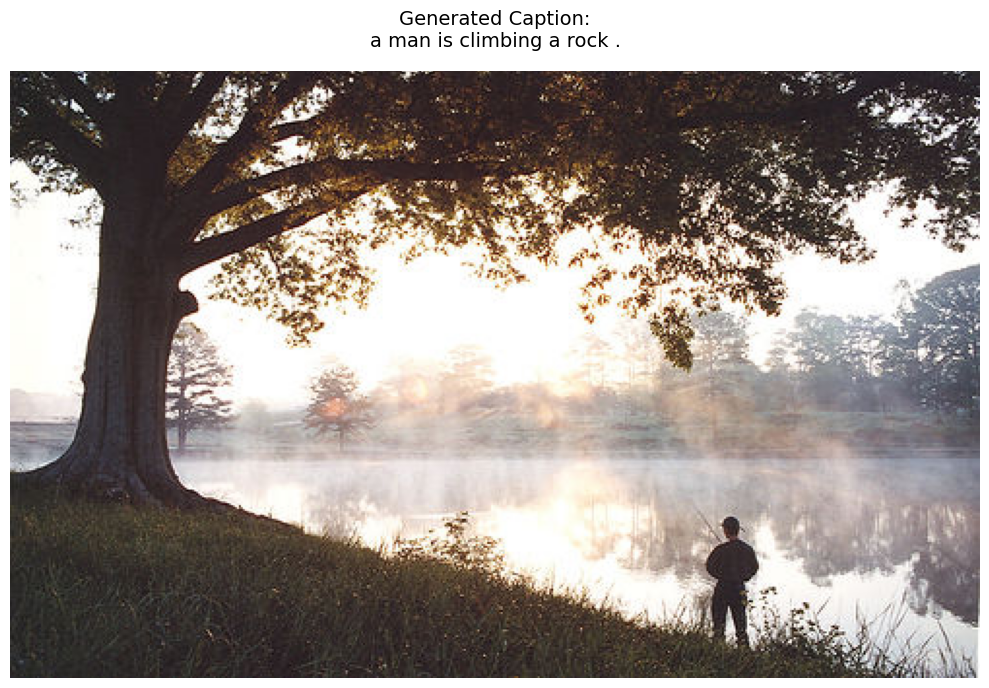


Generated Caption: a man is climbing a rock .


In [11]:
# MODIFY THIS PATH to your test image
TEST_IMAGE_PATH = '../test_images/5.jpg'

# Option 1: Upload image from your computer
# from google.colab import files
# uploaded = files.upload()
# TEST_IMAGE_PATH = list(uploaded.keys())[0]

# Generate caption using greedy decoding
print("\n" + "="*80)
print("GREEDY DECODING")
print("="*80)
caption_greedy = generate_and_display_caption(
    model, vocab, TEST_IMAGE_PATH, device=device, use_beam_search=False
)


BEAM SEARCH (Better Quality)
Generating caption using beam search (beam_width=5)...


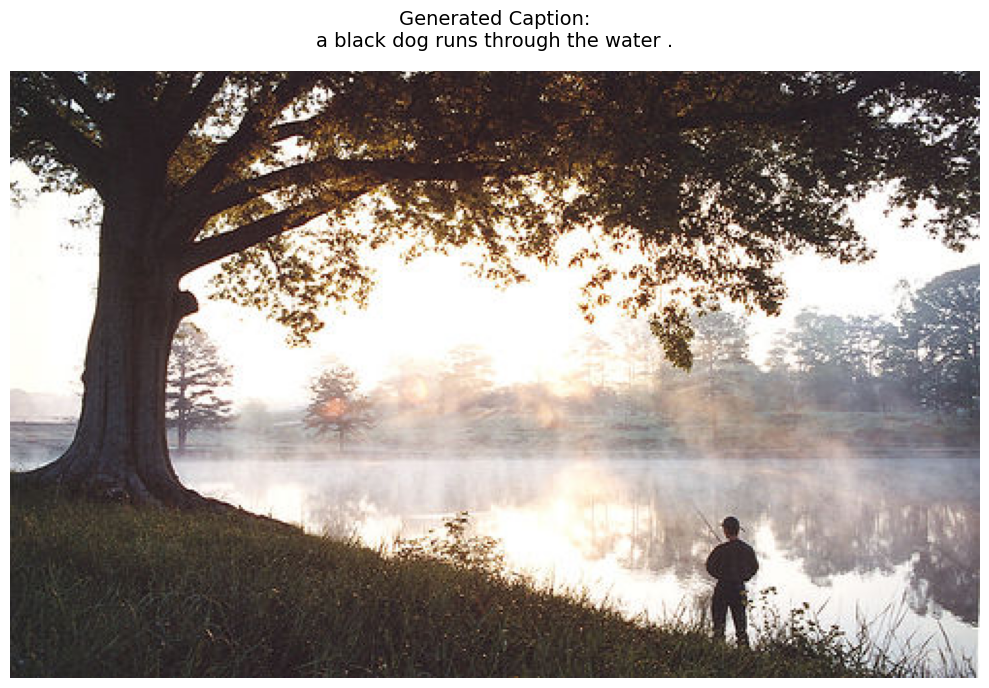


Generated Caption: a black dog runs through the water .


In [35]:
# Generate caption using beam search (usually produces better captions)
print("\n" + "="*80)
print("BEAM SEARCH (Better Quality)")
print("="*80)
caption_beam = generate_and_display_caption(
    model, vocab, TEST_IMAGE_PATH, device=device, use_beam_search=True, beam_width=5
)

## Test on Multiple Images

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/image_captioning/test1.jpg'

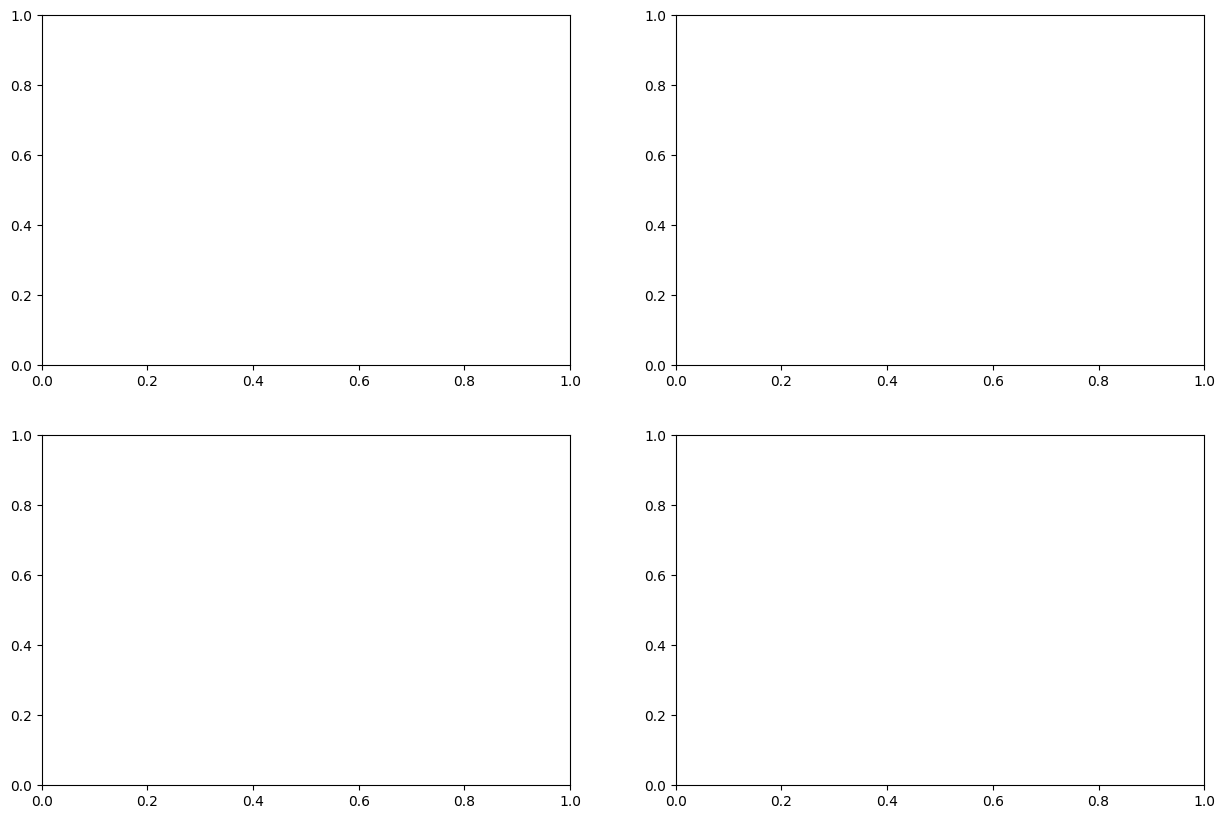

In [36]:
# Test on multiple images
test_image_paths = [
    '/content/drive/MyDrive/image_captioning/test1.jpg',
    '/content/drive/MyDrive/image_captioning/test2.jpg',
    '/content/drive/MyDrive/image_captioning/test3.jpg',
    '/content/drive/MyDrive/image_captioning/test4.jpg',
]

test_multiple_images(model, vocab, test_image_paths, device=device, use_beam_search=True)

## Upload and Test Any Image

In [ ]:
# Upload an image from your computer and test it
from google.colab import files

print("Upload an image to test:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"\nTesting on: {filename}")
    caption = generate_and_display_caption(
        model, vocab, filename, device=device, use_beam_search=True, beam_width=5
    )